In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

# load pickle module
import pickle

In [2]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [3]:
pop = np.loadtxt('../data/pop_new.csv')

In [4]:
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025])
over_rs = 1/rs
len_r = len(rs)
Ensembles = np.zeros((len(rs),300,3142,60))

In [10]:
R0 = 2.5
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
for r_idx in range(len_r):
#     print(r_idx)
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    for i in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(i+1))
        temp = load_gzipped_numpy(export_names)
        if len(temp) == 1:
            print(r, i)
        else:
            Ensembles[r_idx,i,:,:] = temp

In [11]:
Ensembles_0 = copy.deepcopy(Ensembles)
Ensembles_0[Ensembles_0 == 0] = 0.000000000000001
Ensembles_log = np.log(Ensembles_0)

In [12]:
M_r_logNewinfect_avg = np.average(Ensembles_log,axis=1)
M_r_logNewinfect_std = np.std(Ensembles_log,axis=1)

In [10]:
M_r_logNewinfect_avg.shape

(9, 3142, 60)

In [13]:
import networkx as nx
WN = np.loadtxt('W_avg.csv')
g_m = nx.from_numpy_array(WN)
g_m.remove_edges_from(nx.selfloop_edges(g_m))
neighbours = list(g_m.neighbors(1858))
second_neighbours = []
for n in neighbours:
    s_n = list(g_m.neighbors(n))
    second_neighbours.extend(s_n)
second_neighbours = list(set(second_neighbours))
all_neighbours = neighbours + second_neighbours

In [14]:
# position = list(set(neighbours))
position = list(set(all_neighbours))

In [15]:
edge_weights = nx.get_edge_attributes(g_m, "weight")
edge_width = np.array(list(edge_weights.values()))*2

In [16]:
WN2 = np.dot(WN, WN)
WN3 = WN@WN@WN

In [17]:
R_loglikelihood_sum = np.zeros((9,300,9))# the first r is for the ground truth, the second r (axis=2) is the possible r
weight = (WN+WN2)[position,1858] ### different ranges
# R_loglikelihood_maxtrix = dict()
for r_idx in range(9):
    r = rs[r_idx]
    for e_i in range(300):
        observed_ts = Ensembles_log[r_idx,e_i,:,7:]
        mle_matrix = observed_ts[position]
        for r_j in range(9):
            mean_r = M_r_logNewinfect_avg[r_j,position,7:]
            std_r = M_r_logNewinfect_std[r_j,position,7:]
        #     std_r_ma = mean_county_r*0.1+1
            M_likelihood = SSA.norm.pdf(mle_matrix, scale=std_r, loc=mean_r)
            M_likelihood[M_likelihood==0]=0.0000001
    #         R_loglikelihood_maxtrix[(r_idx,r_j)] = np.log(M_likelihood)
            R_loglikelihood_sum[r_idx, e_i, r_j] = np.sum(np.log(M_likelihood[:,10:])*weight[:,None])#

In [18]:
loglikelihood_ranges_avg = np.mean(R_loglikelihood_sum,axis=1)
# loglikelihood_ranges_avg = np.median(R_loglikelihood_sum,axis=1)
loglikelihood_ranges_std = np.std(R_loglikelihood_sum,axis=1)
loglikelihood_ranges_errorbar = loglikelihood_ranges_std/np.sqrt(300)

In [15]:
R_loglikelihood_sum.shape

(9, 300, 9)

In [19]:
loglikelihood_ranges_25 = np.quantile(R_loglikelihood_sum,q=0.05,axis=1)
loglikelihood_ranges_95 = np.quantile(R_loglikelihood_sum,q=0.95,axis=1)

In [41]:
np.quantile(R_loglikelihood_sum[-1,:,0],0.25)

-3537.615768608408

(array([2.03533733e-06, 4.07067467e-06, 2.03533733e-06, 4.07067467e-06,
        2.03533733e-06, 2.03533733e-06, 4.07067467e-06, 2.03533733e-06,
        2.03533733e-06, 2.03533733e-06, 1.01766867e-05, 6.10601200e-06,
        1.01766867e-05, 8.14134933e-06, 6.10601200e-06, 2.03533733e-05,
        2.84947227e-05, 5.08834333e-05, 8.14134933e-05, 3.62290045e-04]),
 array([-32847.91074404, -31210.18058531, -29572.45042658, -27934.72026786,
        -26296.99010913, -24659.2599504 , -23021.52979167, -21383.79963295,
        -19746.06947422, -18108.33931549, -16470.60915676, -14832.87899803,
        -13195.14883931, -11557.41868058,  -9919.68852185,  -8281.95836312,
         -6644.2282044 ,  -5006.49804567,  -3368.76788694,  -1731.03772821,
           -93.30756949]),
 <BarContainer object of 20 artists>)

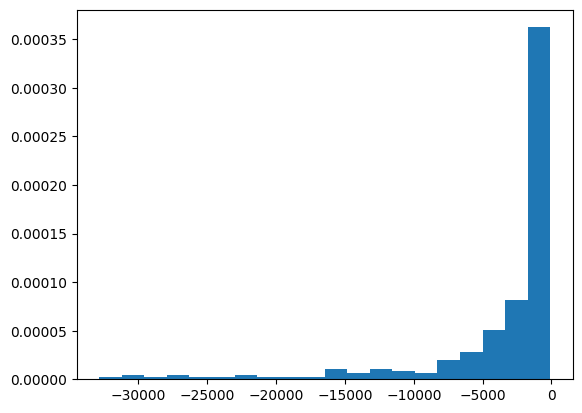

In [42]:
plt.hist(R_loglikelihood_sum[-1,:,0],density=True,bins=20)

In [21]:
line_properties = dict(linestyle='-', linewidth=0.75, color='royalblue')

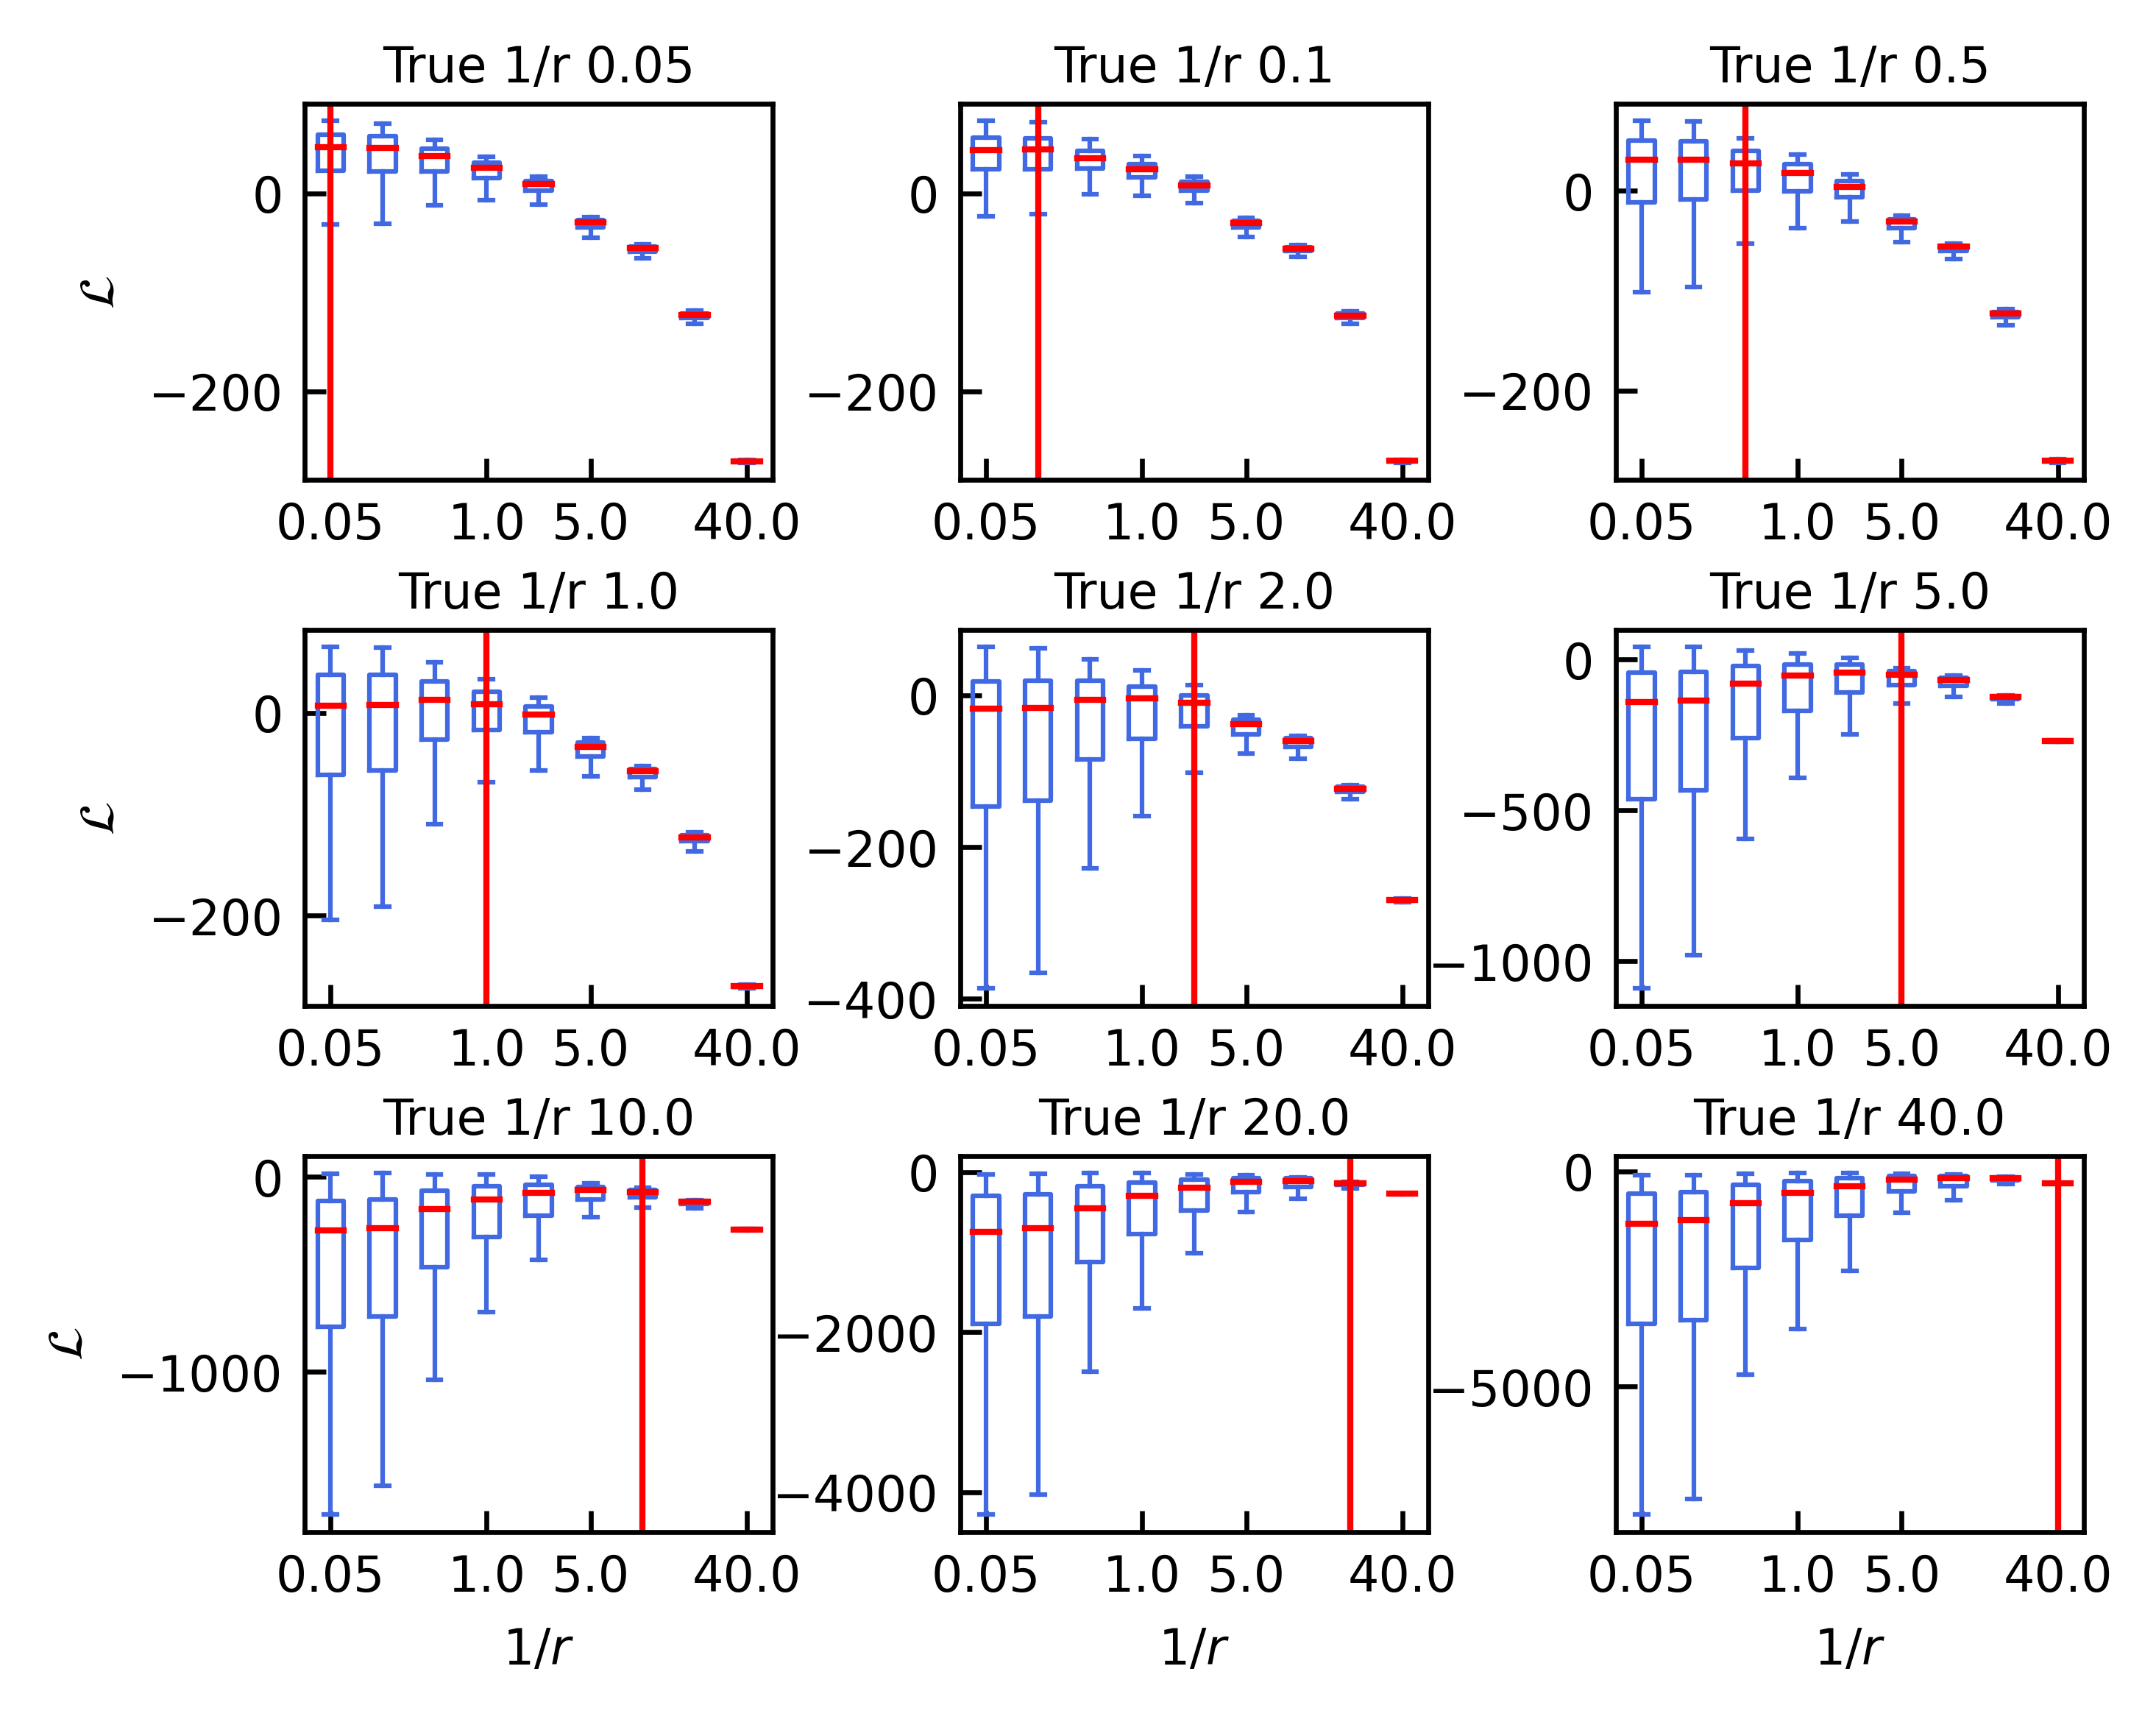

In [32]:
# plt.rcParams['font.family'] = 'Times New Roman' 
fig, axs = plt.subplots(3,3,figsize=(5.2,4.2),dpi=600)
for i in range(9):
    row = int((i)/3)
    col = int((i)%3)
    ax = axs[row,col]
    pos_le = - loglikelihood_ranges_avg[i,:]
    mle = np.where(pos_le == np.min(pos_le))[0][0]
#     print(mle)
    r = rs[i]
    y = loglikelihood_ranges_avg[i,:]
#     y_e =  loglikelihood_ranges_errorbar[i,:]*1.98 ##1.98 is the value for confidence level 95% for t statistics
    y_e_lower = loglikelihood_ranges_25[i,:]
    y_e_upper = loglikelihood_ranges_95[i,:]
#     ax.scatter(range(1,10), y, label = 'observed r {}'.format(np.round(r,2)),s=5,color='royalblue')
#     ax.fill_between(range(1,10), y_e_lower,
#                  y_e_upper,color='royalblue',alpha=0.3)
    
    ax.boxplot(R_loglikelihood_sum[i,:],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='royalblue'),
               whiskerprops=line_properties,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=1, color='red'))
#     ax.fill_between(range(1,10), y-y_e,
#                  y+y_e,color='royalblue',alpha=0.3)
    ax.axvline(mle+1, color='red',label='maxmise -log(likeli)',lw=1)#     
    
    ax.set_xticks([1,4,6,9])
    ax.set_xticklabels(np.round(1/rs[[0,3,5,8]],3),fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(direction='in')
    if row == 2:
        ax.set_xlabel(r'$1/r$',fontsize=8)
        
    if col == 0:  # First column
        ax.set_ylabel(r"$\mathcal{L}$", fontsize=8)
#     ax.legend(frameon=False)
    ax.set_title('True 1/r {}'.format(np.round(1/r,3)),fontsize=8,y=0.96)
#     ax.set_yscale('log')

plt.subplots_adjust(wspace=0.4,hspace=0.4)
# plt.tight_layout(pad=0.1)
# plt.show()
# plt.savefig('likelihood_box.eps', format='eps')
plt.savefig('likelihood_box.pdf')

In [22]:
### for a give r
r_loglikelihood_ranges = R_loglikelihood_sum[0]

In [41]:
loglikelihood_ranges_std

array([32.20696989, 30.57911122, 19.32357223, 13.39736389,  8.98933668,
        6.2114434 ,  9.94978853,  2.92814612,  5.49089549])